# The fast Fourier transform

We consider a question: ***How to Efficiently compute multiplication of polunomial***?
i.e.
> For two given degree-$d$ polynomial $A(x)=\sum^d_{i=0}a_ix^i, B(x)=\sum^d_{i=0}b_ix^i$, we want to compute the product of them:
> $$
C(x)=A(x)\cdot B(x)=\sum^{2d}_{i=0}c_ix^i\\
where\ c_i=\sum_{j=0}^ia_jb_{i-j}
> $$

Obviously there is a fact that:
> A degree-$d$ polynomial $A(x)=\sum^d_{i=0}a_ix^i$ is determinated by $d+1$ values:
> 1. Its coefficients:
> $$
a_0,a_1,\dots a_d
> $$
> 2. Its distinct n (argument,value)-pairs
> $$
> (x_0, A(x_0)),\dots, (x_{d+1},A(x_{d+1}))
> $$

If we calculate the coefficients of $C(x)$.  
i.e. by the equation $c_i=\sum_{j=0}^ia_jb_{i-j}$, then the time complexity is $O(m^2)$. 


There is a another viewpoint to consider the above two things:
Note that:
$$
\begin{bmatrix}
A(x_0)\\
A(x_1)\\
\dots\\
A(x_d)
\end{bmatrix}=
\begin{bmatrix}
&x_0^0 &x_0^1 &\dots &x_0^d\\
&x_1^0 &x_1^1 &\dots &x_1^d\\
&\dots &\dots &\dots &\dots\\
&x_d^0 &x_d^1 &\dots &x_d^d\\
\end{bmatrix}
\begin{bmatrix}
a_0\\
a_1\\
\dots\\
a_d
\end{bmatrix}
$$
If the $d+1$ variables $x_i$ are distinct, then the matrix in middle(we express as $M$) is invertible, so we can multiple $M/M^{-1}$ to transfer between coefficients and values.

In [9]:
import cmath

In [10]:
class Polynomial:
    def __init__(self, coefficients: list) -> None:
        coefficients = coefficients.copy()
        while len(coefficients) > 1 and coefficients[-1] == 0:
            coefficients.pop()
        self.coefficients = coefficients# From the constant item to the heightest degree
        self.degree = len(coefficients) - 1
        
    def __call__(self, x: int | float | complex)-> int | float | complex:
        return self.value_of(x)
    
    def value_of(self, x: int | float | complex)-> int | float | complex:
        result = 0
        for i, c in enumerate(self.coefficients):
            result += c * (x ** i)
        return result
    
    def __bool__(self)-> bool:
        return any(c != 0 for c in self.coefficients)
    
    def __eq__(self, value: object) -> bool:
        if not isinstance(value, Polynomial):
            return False
        return self.coefficients == value.coefficients
    
    def __str__(self) -> str:
        result = ""
        for i,c in enumerate(self.coefficients):
            if i == 0: 
                result = str(c)
            elif i == 1:
                result += f" + {c}x"
            else:
               result += f" + {c}x^{i}"
        return result
    
    def __repr__(self) -> str:
        return f"Polynomial({self.coefficients})"
    
    def __add__(self, other: object)-> 'Polynomial':
        if isinstance(other, (int, float, complex)):
            newCoeffs = self.coefficients.copy()
            newCoeffs[0] += other
            return Polynomial(newCoeffs)
        elif isinstance(other, Polynomial):
            newDegree = max(self.degree, other.degree)
            newCoeffs = []
            for i in range(newDegree + 1):
                tem = 0.0
                if i < len(self.coefficients):
                    tem += self.coefficients[i]
                if i < len(other.coefficients):
                    tem += other.coefficients[i]
                newCoeffs.append(tem)
            return Polynomial(newCoeffs)
        else:
            return NotImplemented
        
    def __radd__(self, other: object)-> 'Polynomial':
        return self + other
    
    def __sub__(self, other: object)-> 'Polynomial':
        if isinstance(other, (int, float, complex)):
            newCoeffs = self.coefficients.copy()
            newCoeffs[0] -= other
            return Polynomial(newCoeffs)
        elif isinstance(other, Polynomial):
            newDegree = max(self.degree, other.degree)
            newCoeffs = []
            for i in range(newDegree + 1):
                tem = 0.0
                if i < len(self.coefficients):
                    tem += self.coefficients[i]
                if i < len(other.coefficients):
                    tem -= other.coefficients[i]
                newCoeffs.append(tem)
            return Polynomial(newCoeffs)
        else:
            return NotImplemented
        
    def __neg__(self) -> 'Polynomial':
        newCoeff = [-self.coefficients[i] for i in range(self.degree + 1)]
        return Polynomial(newCoeff)
        
    def __rsub__(self, other: object)-> 'Polynomial':
        return - (self - other)
        
    
    def __mul__(self, other: object)-> 'Polynomial':
        if isinstance(other, (int, float, complex)):
            newCoeffs = [self.coefficients[i] * other for i in range(self.degree + 1)]
            return Polynomial(newCoeffs)
        elif isinstance(other, Polynomial):
            newDegree = self.degree + other.degree
            newCoeffs = []
            for i in range(newDegree + 1):
                tem = 0.0
                for j in range(i + 1):
                    if (j > self.degree) or (i-j > other.degree):
                        continue
                    tem += self.coefficients[j] * other.coefficients[i-j]
                newCoeffs.append(tem)
            return Polynomial(newCoeffs)
        else:
            return NotImplemented
        
    def __rmul__(self, other: object)-> 'Polynomial':
        return self * other
    
    def __pow__(self, power: int)-> 'Polynomial':
        if not isinstance(power, int) or power < 0:
            return NotImplemented
        if power == 0:
            return Polynomial([1])
        result = Polynomial([1])
        base = self
        while power > 0:
            if power % 2 == 1:
                result = result * base
            base = base * base
            power //= 2
        return result

But what if we condiser the values of $A(x)$ and $B(x)$?
## Compute the products of values!

Its seems more simple. We need 4 steps to product two polynomial:
+ Polunomial Multiplication
  + Input: Coefficients of two polynomials, $A(x)$ and $B(x)$, of degree $d$
  + Output: Their product $C=A·B$
  + **Selection**
    + Pick some points $x_0,x_1,...,x_{n−1}$, where $n≥2d+1$
  + **Evaluation**
    + Compute $A(x_0),A(x_1),...,A(x_{n−1})$ and $B(x_0),B(x_1),...,B(x_{n−1})$
  + **Multiplication**
    + Compute $C(x_k) = A(x_k)B(x_k)$ for all $k=0,...,n−1$
  + **Interpolation**
    + Recover $C(x) = c_0 + c_1x+···+ c_2^dx_2^d$

We skip the selection, analyse the evaluation first.
## 1. Evaluation
When we directly compute the value of each point of $A(x)=\sum^d_{i=0}a_ix^i$, it's a $O(d)$ scale problem, that we need compute all  $d$ items of the polynomial. But consider the following case:
> If we choose two point $t$ and $-t$, then we have
> $$
\begin{aligned}
&A(t) = \sum^d_{i=0}a_it^i\\
&A(-t) = \sum^d_{i=0}a_i(-t)^i = \sum^d_{\text{i is even}}a_it^i - \sum^d_{\text{i is odd}}a_it^i\\
\end{aligned}
> $$ 

More generally, we define that:
$$
A(x) = A_{e}(x^2) + xA_o(x^2)
$$
where $A_e$ donates the even-numbered coeffcients(e.g. $a_0, a_2,\dots$), $A_o$ donates the odd-numbered coeffcients.

We divide the problem into two half subproblem, with linearly time! 
i.e. 
$$
T(n) = 2T(\frac{n}{2})+O(n)
$$

But obviously there is a **BUG**! Note that $A_{e/o}(x^2)$'s argument is $x^2$, thus we can't directly find a rational variable that its square is $-x^2$. So to make the recurse process continue, we consider to expend the domain to $\mathbb{C}$!

Consider we use **complex n-th roots of unity** $w$, where $w=e^{2\frac{\pi}{n}i}$. So that we have the following properties:
$$
\begin{align}
&1,w,w^2,\dots w^{n-1}\text{ are distinct!}\\
&w^n=1\\
\end{align}
$$

Note that under module $n$, $\{0,1,\dots n-1\}\rightarrow^{\times 2}\{0,2,\dots\}$. We assume that $n$ is even, then each root $w^i$ has a unique coordinate root $w^j$, where $2i\equiv \pmod{n}$, i.e. $(w^i)^2 = (w^j)^2$! Then we have efficient finish the **sellection** and **evaluation** process!
We have:
$$
\begin{aligned}
&j = i + \frac{n}{2} \pmod{n}\\
&A(w^i) = A_e(w^{2i}) + w^iA_o(w^{2i})\\
&A(w^j) = A_e(w^{2j}) + w^jA_o(w^{2j}) = A_e(w^{2i}) + w^jA_o(w^{2i})\\
\end{aligned}
$$

In [11]:
def dividePolynomial(p:'Polynomial')->list[Polynomial]:
    coeffAo, coeffAe = [], []
    for i, c in enumerate(p.coefficients):
        if i%2 == 0:
            coeffAe.append(c)
        else:
            coeffAo.append(c)
    return [Polynomial(coeffAo), Polynomial(coeffAe)]

def generateNthRoots(n: int):
    return [cmath.exp(2j * cmath.pi * k / n) for k in range(n)]

def evaluate(n: int, p:'Polynomial')-> dict[complex,complex]:
    roots = generateNthRoots(n)
    if n == 1:
        return {roots[0]: p(roots[0])}
    
    #n must be power of 2
    tem = n
    while tem > 1:
        if tem%2 == 1:
            raise NotImplementedError
        tem = tem//2
    
    Ao, Ae = dividePolynomial(p)
    result = dict()
    subroots = generateNthRoots(n//2)
    resultAo = evaluate(n//2, Ao)
    resultAe = evaluate(n//2, Ae)
    for i in range(n//2):
        result[roots[i]] = resultAe[subroots[i]] + roots[i] * resultAo[subroots[i]]
        result[roots[i + n//2]] = resultAe[subroots[i]] - roots[i] * resultAo[subroots[i]]
    return result
        
        

Polynomial: 1 + 2x + 3x^2 + 4x^3
Evaluating at the 4-th roots of unity...

p(1.000+0.000j) = 10.000+0.000j
p(-1.000+0.000j) = -2.000+0.000j
p(0.000+1.000j) = -2.000-2.000j
p(-0.000-1.000j) = -2.000+2.000j
Checking correctness by comparing with direct evaluation:
✅ All values match!


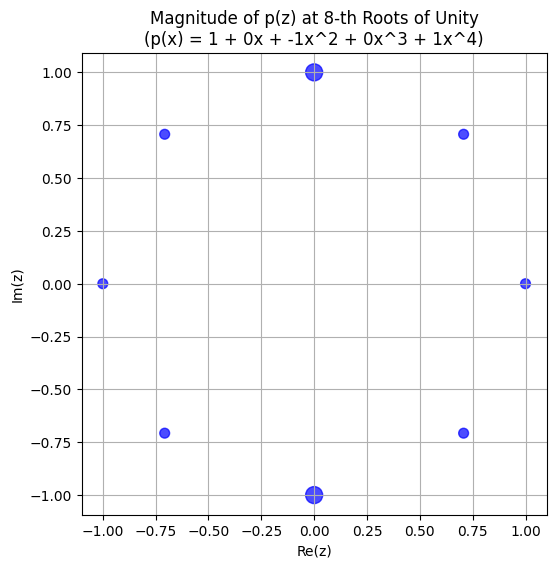

In [12]:
#Test of evaluate (Generate by Qwen3)
# Example polynomial: p(x) = 1 + 2x + 3x^2 + 4x^3
p = Polynomial([1, 2, 3, 4])
n = 4  # must be power of 2

print(f"Polynomial: {p}")
print(f"Evaluating at the {n}-th roots of unity...\n")

result = evaluate(n, p)

for root, value in result.items():
    print(f"p({root:.3f}) = {value:.3f}")

# Cross-check with direct evaluation
roots = generateNthRoots(n)
direct_eval = {root: p(root) for root in roots}

print("Checking correctness by comparing with direct evaluation:")
all_close = True
for root in roots:
    fft_val = result[root]
    direct_val = direct_eval[root]
    if abs(fft_val - direct_val) > 1e-10:
        print(f"Mismatch at {root}: FFT={fft_val}, Direct={direct_val}")
        all_close = False

if all_close:
    print("✅ All values match!")
else:
    print("❌ Some values differ.")

import matplotlib.pyplot as plt

# Use n=8 for richer visualization
p2 = Polynomial([1, 0, -1, 0, 1])  # e.g., 1 - x^2 + x^4
n2 = 8
evals = evaluate(n2, p2)

roots = list(evals.keys())
magnitudes = [abs(val) for val in evals.values()]

plt.figure(figsize=(6, 6))
plt.scatter([z.real for z in roots], [z.imag for z in roots], 
            s=[m*50 for m in magnitudes], alpha=0.7, c='blue')
plt.title(f"Magnitude of p(z) at {n2}-th Roots of Unity\n(p(x) = {p2})")
plt.xlabel("Re(z)")
plt.ylabel("Im(z)")
plt.axis('equal')
plt.grid(True)
plt.show()

The next problem is **How to use the n (argument, value)-pairs to recover the function**?

# 2. Interpolation